In [2]:
import json
import utils
from utils import preds_reformat
from models.ours.initial_design import EnsembleModel

%matplotlib inline

In [3]:
ensemble = EnsembleModel(bodydet_arch="faster_rcnn",
                         baseline_bodypred=True,
                         bodypred_backbone="efficientnet",
                         bodypred_size="tiny")

imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/mmfashion_sample_images/WOMEN_Blouses_Shirts_id_00004189_07_1_front.jpg"
preds = ensemble.predict(imgpath)
preds

[{'bbb': (130, 0, 618, 1094),
  'fbb': (302, 54, 438, 245),
  'body_score': 0.9984404444694519,
  'face_score': 0.99904805,
  'age': 0.012576889246702194,
  'gender': 0.2589079439640045}]

[{'bbb': (130, 0, 618, 1094), 'fbb': (302, 54, 438, 245), 'age': 'Young', 'gender': 'Woman'}]


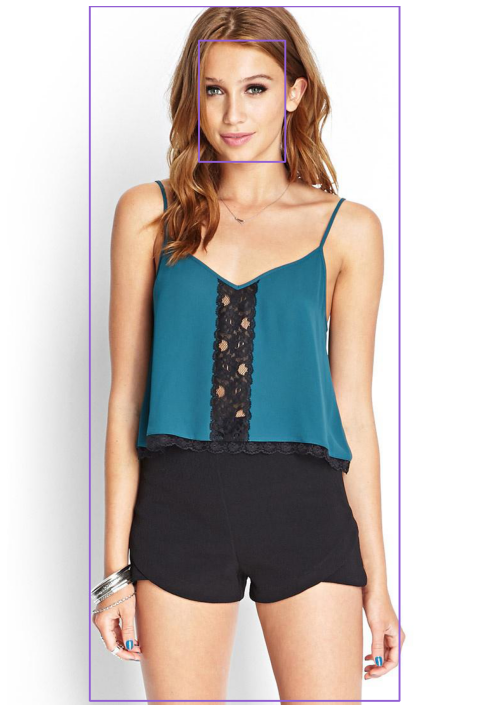

In [58]:
color = (231, 163, 53)
ann = preds_reformat(preds)
print(ann)
utils.show(utils.draw_annotation(imgpath, ann, color="gendered"), cformat="bgr", size=(10, 10))

[{'bbb': (126, 28, 613, 1072), 'fbb': (342, 44, 510, 270), 'body_score': 0.9998457431793213, 'face_score': 0.99924916, 'age': 0.46537700667977333, 'gender': 0.7446042001247406}]


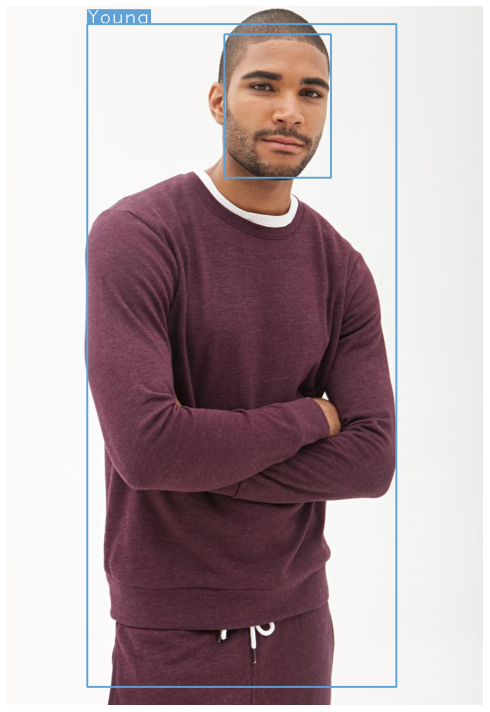

In [59]:
imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/mmfashion_sample_images/MEN_Sweatshirts_Hoodies_id_00004332_03_2_side.jpg"
preds = ensemble.predict(imgpath)
print(preds)

ann = preds_reformat(preds)
utils.show(utils.draw_annotation(imgpath, ann, color="gendered"), cformat="bgr", size=(10, 10))

[{'bbb': (27, 0, 724, 1080), 'fbb': (395, 35, 544, 238), 'body_score': 0.9975385665893555, 'face_score': 0.99478394, 'age': -0.04322772100567818, 'gender': 0.2405586689710617}]


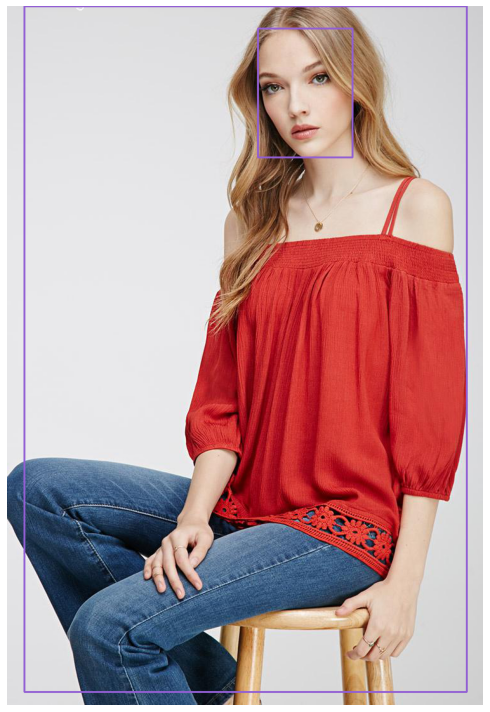

In [60]:
imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/mmfashion_sample_images/WOMEN_Blouses_Shirts_id_00001741_01_1_front.jpg"
preds = ensemble.predict(imgpath)
print(preds)

ann = preds_reformat(preds)
utils.show(utils.draw_annotation(imgpath, ann, color="gendered"), cformat="bgr", size=(10, 10))

100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


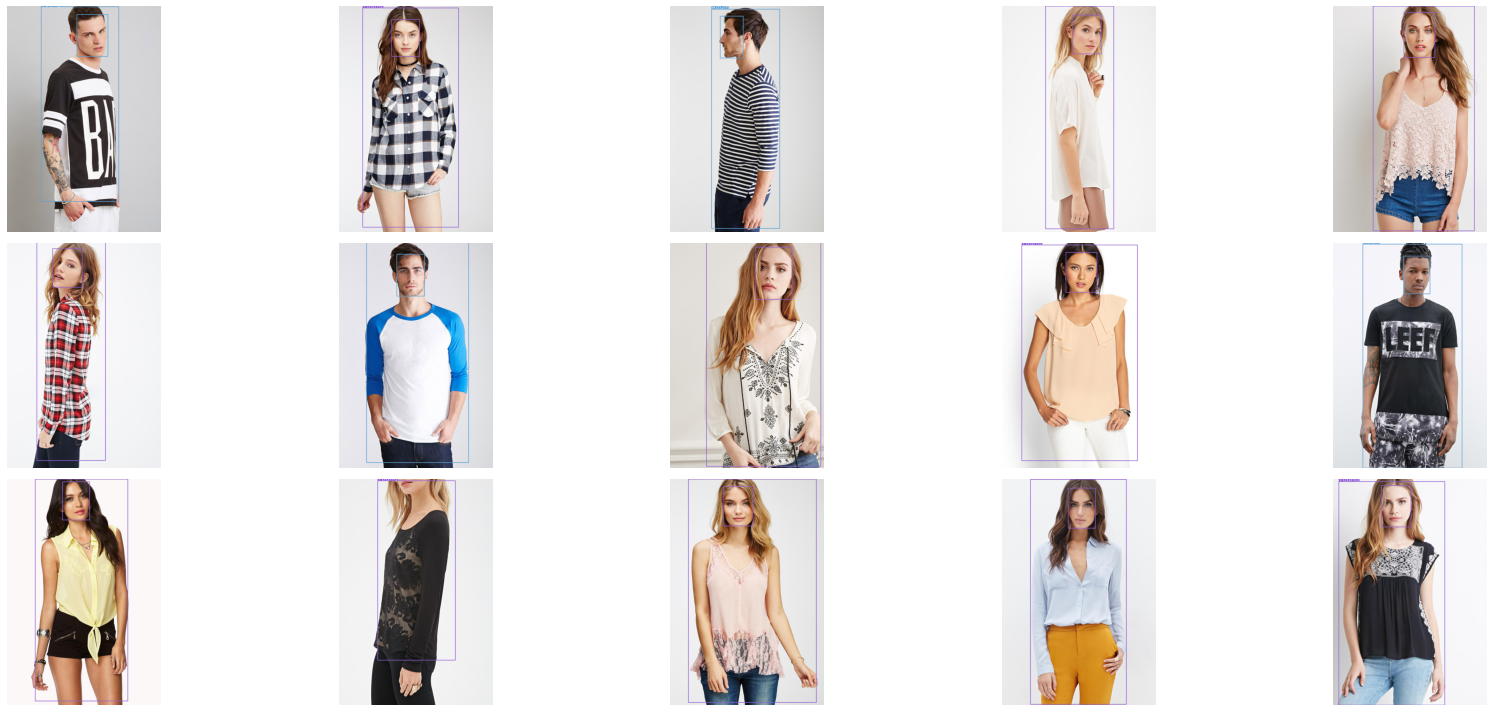

In [5]:
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import ceil

mmfsample_dataset = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/mmfashion_sample_images"
ensemble = EnsembleModel(bodydet_arch="faster_rcnn",
                         baseline_bodypred=True,
                         bodypred_backbone="efficientnet",
                         bodypred_size="tiny")

ncols, nrows = 5, 14
ntotal = ncols * nrows
fig, axs = plt.subplots(ceil(ntotal/ncols), ncols, figsize=(25,80))
plt.axis("off")

for i, imgpath in tqdm(enumerate([os.path.join(mmfsample_dataset, imgname) for imgname in utils.os.listdir(mmfsample_dataset)[:ntotal]]), total=ntotal):
    ann = preds_reformat(ensemble.predict(imgpath))
    cv2_img = utils.draw_annotation(imgpath, ann, color="gendered")
    axs[i//ncols, i%ncols].imshow(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
    axs[i//ncols, i%ncols].axis('off')
fig.tight_layout()
plt.show()

In [1]:
import json
import torch
import utils
from models.ours.initial_design import EnsembleModel, bbox_pairing, metrics, extract_field
%matplotlib inline

In [2]:
ensemble = EnsembleModel(conf_thrs=0.9)
state_dict_path = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/trained_models/body/exp_baseline_finalmodel/state_dict.pth"
ensemble.load_body_statedict(torch.load(state_dict_path, map_location=torch.device('cpu')))

Age model state dict has been successfully loaded.
Gender model state dict has been successfully loaded.


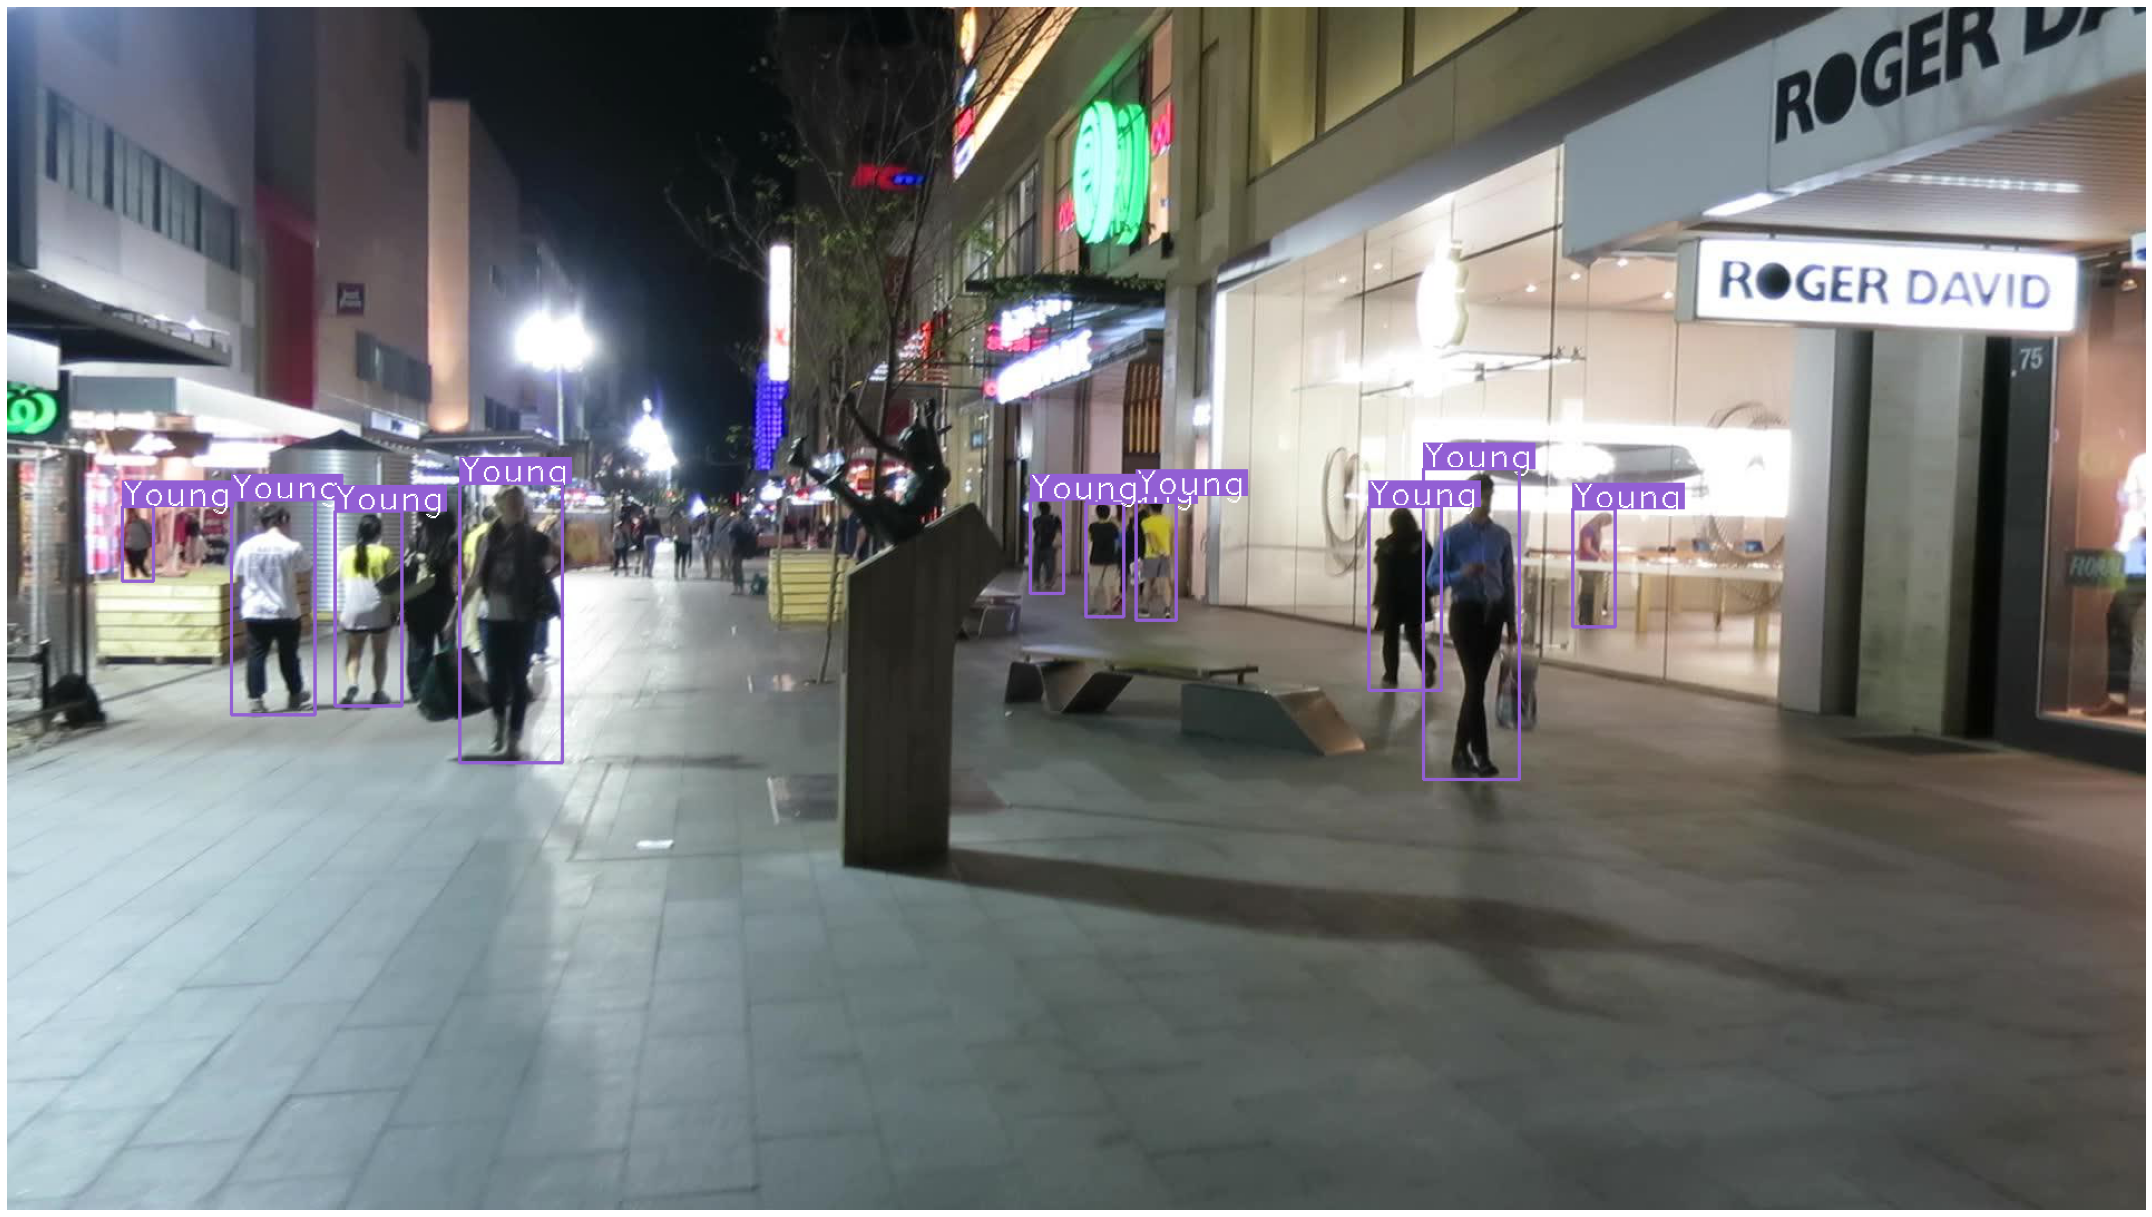

In [65]:
imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/curated/MOT17-10_resampled-fin/000029.jpg"
preds = ensemble.predict(imgpath)
ann = utils.preds_reformat(preds)
utils.show(utils.draw_annotation(imgpath, ann, color="gendered"), size=(30, 30), cformat="bgr")

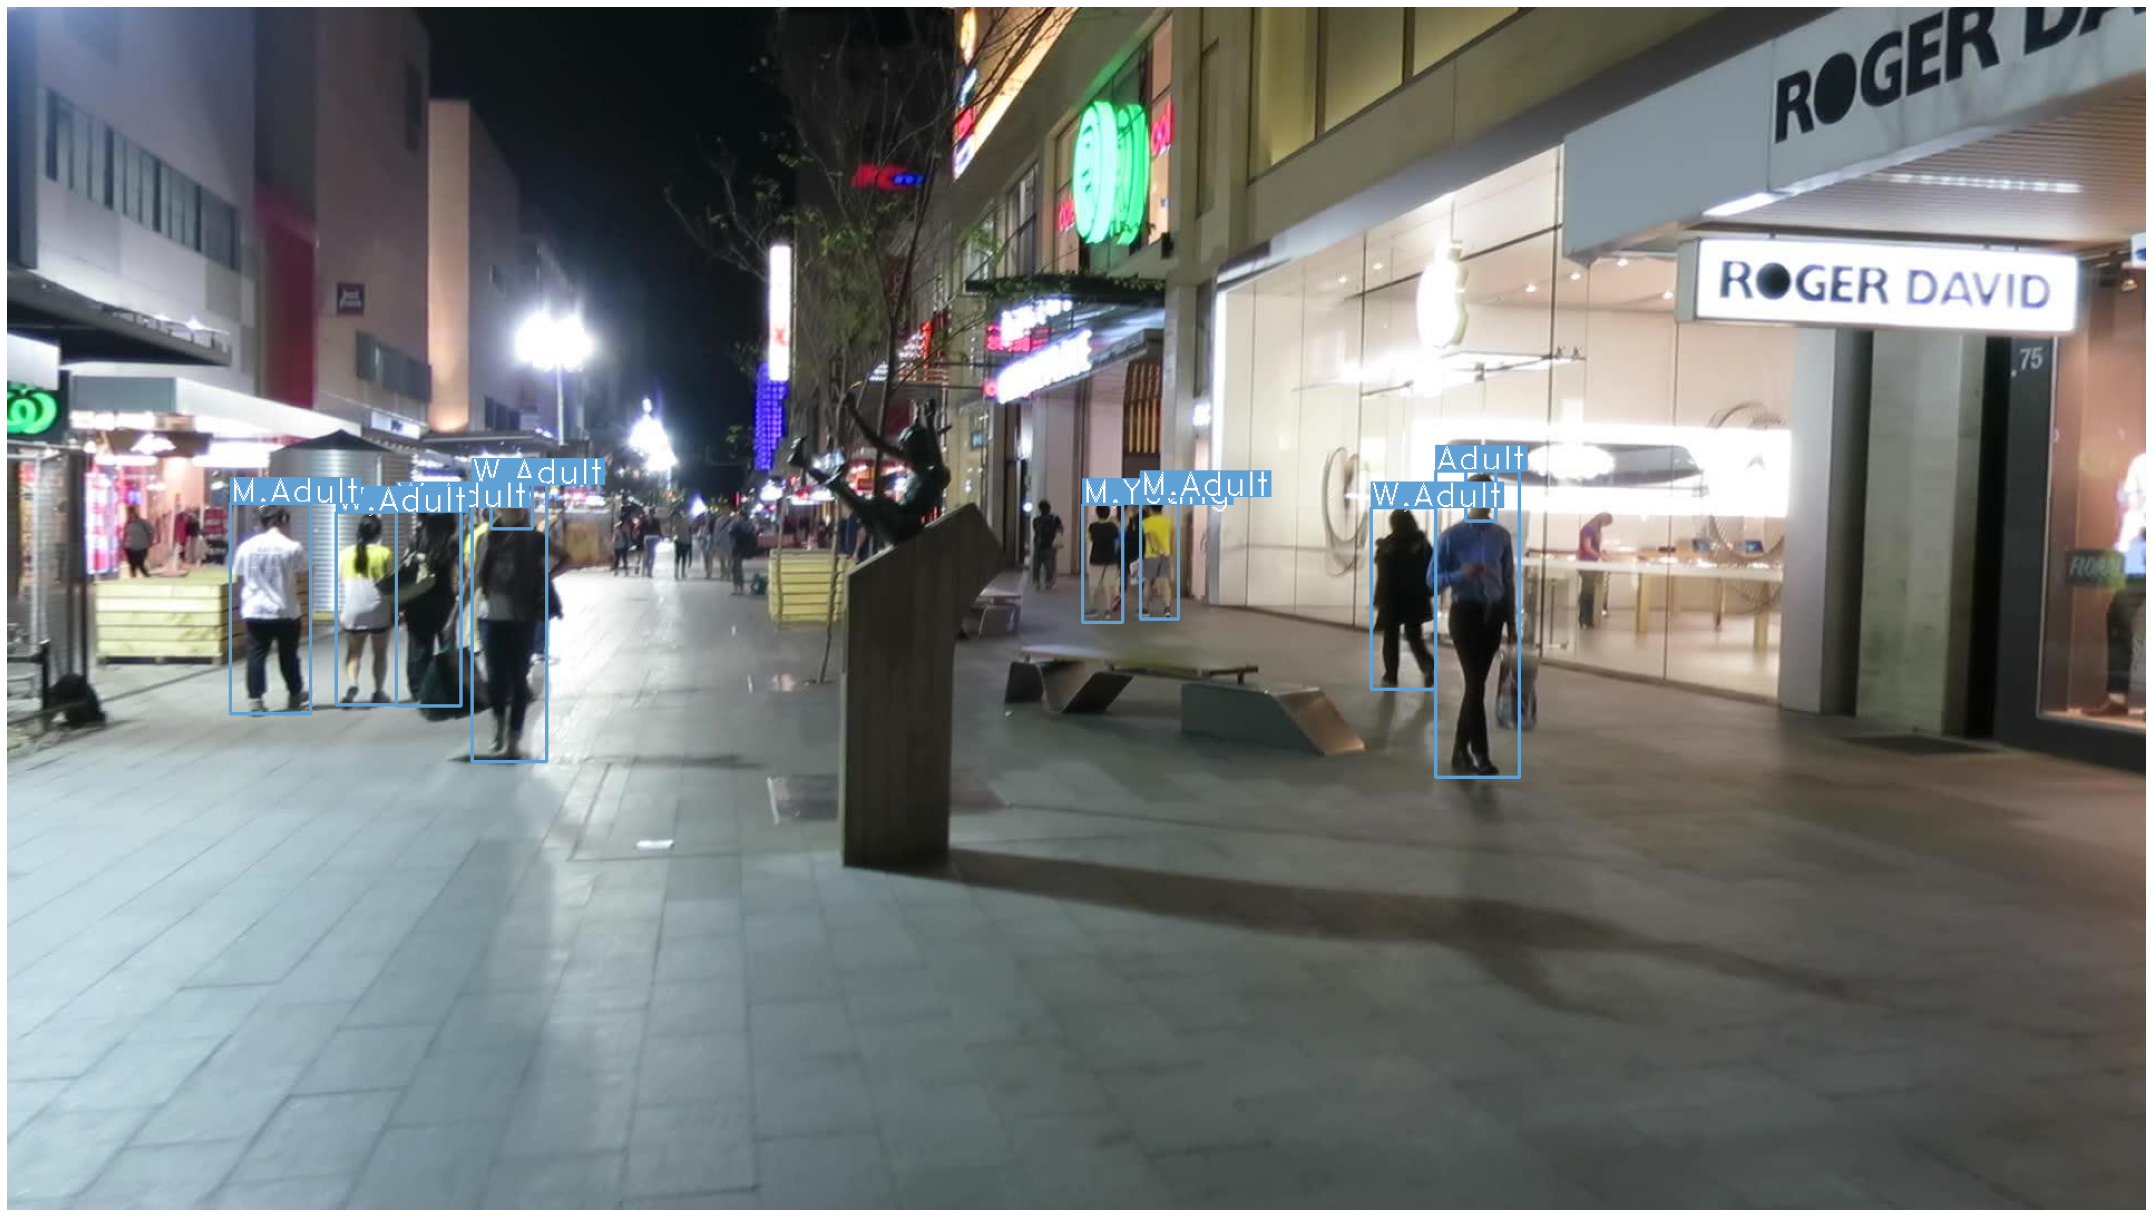

In [66]:
curated_file = open("/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/MOT17-10/annotations/curated.json", 'r')
GT_MOT17 = json.load(curated_file)
curated_file.close()
utils.show(utils.draw_annotation(imgpath, utils.preds_reformat(GT_MOT17[imgpath]), color="gendered"), size=(30, 30), cformat="bgr")

In [67]:
body_pairs = bbox_pairing(extract_field(preds, field="bbb"), extract_field(GT_MOT17[imgpath], field="bbb"))
metrics(body_pairs)

{'recall': 0.875, 'precision': 0.7, 'f1': 0.7777777777777779}

In [8]:
body_pairs = bbox_pairing(extract_field(preds, field="fbb"), extract_field(GT_MOT17[imgpath], field="fbb"))
metrics(body_pairs)

{'recall': 0, 'precision': 0, 'f1': 0}

In [9]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def torchmetrics_formatter(preds_by_frames, bpart:str, gt:bool=False):
    if bpart not in ['body', 'face']:
        raise ValueError(f"Body part {bpart} not in ['body', 'face'].")
    bbox_field, score_field = ('bbb', 'body_score') if bpart == "body" else ('fbb', 'face_score')
    frames = []
    for preds in preds_by_frames:
        boxes, scores = [], []
        for bbox, score in [(p[bbox_field], p[score_field] if not gt else None) for p in preds if p[bbox_field] is not None]:
            boxes.append(bbox); scores.append(score) if not gt else None
        if gt:
            frames.append({'boxes':torch.tensor(boxes), 'labels':torch.tensor([0]*len(boxes))})
        else:
            frames.append({'boxes':torch.tensor(boxes), 'labels':torch.tensor([0]*len(boxes)), 'scores':torch.tensor(scores)})
    return frames

In [46]:
torchmetrics_formatter([preds], "body")

[{'boxes': tensor([[ 201,  442,  276,  635],
          [1271,  414, 1357,  693],
          [ 406,  427,  498,  678],
          [1222,  448, 1287,  613],
          [ 294,  452,  354,  627],
          [ 968,  445, 1002,  547],
          [1013,  438, 1049,  550],
          [ 103,  448,  131,  515],
          [ 918,  442,  948,  526],
          [1405,  450, 1443,  556],
          [ 345,  447,  408,  625]]),
  'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'scores': tensor([0.9984, 0.9983, 0.9980, 0.9968, 0.9868, 0.9863, 0.9827, 0.9821, 0.9815,
          0.9614, 0.9047])}]

In [47]:
torchmetrics_formatter([items for _,items in GT_MOT17.items()], "body", gt=True)

[{'boxes': tensor([[1237,  295, 1299,  556],
          [1205,  307, 1244,  531],
          [1145,  331, 1190,  472],
          [ 922,  330,  969,  477],
          [ 813,  316,  870,  478],
          [ 613,  334,  657,  430],
          [ 323,  256,  475,  729]]),
  'labels': tensor([0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[ 628,  295,  671,  365],
          [ 308,  236,  453,  581],
          [ 541,  284,  600,  403],
          [ 867,  285,  922,  441],
          [ 948,  289,  999,  438],
          [1178,  281, 1237,  473]]),
  'labels': tensor([0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[ 665,  331,  719,  445],
          [1280,  299, 1343,  566],
          [ 341,  316,  410,  595],
          [ 112,  278,  404,  830],
          [1155,  327, 1205,  469],
          [ 826,  316,  883,  485],
          [ 925,  326,  971,  476],
          [1301,  274, 1402,  587]]),
  'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0])},
 {'boxes': tensor([[ 751,  388,  788,  502],
          [ 717,  387,  748,  514]

In [48]:
torchmetrics_formatter([GT_MOT17[imgpath]], "body", gt=True)

[{'boxes': tensor([[1282,  416, 1357,  691],
          [ 417,  428,  484,  677],
          [ 349,  449,  407,  627],
          [ 965,  446, 1001,  552],
          [1017,  439, 1051,  549],
          [1224,  449, 1282,  612],
          [ 295,  453,  349,  626],
          [ 200,  445,  272,  634]]),
  'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0])}]

In [68]:
mAP = MeanAveragePrecision()
mAP.update(torchmetrics_formatter([preds], "body"), torchmetrics_formatter([GT_MOT17[imgpath]], "body", gt=True))
mAP.compute()

{'map': tensor(0.6304),
 'map_50': tensor(0.8713),
 'map_75': tensor(0.6818),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.7000),
 'map_large': tensor(0.6121),
 'mar_1': tensor(0.1125),
 'mar_10': tensor(0.6500),
 'mar_100': tensor(0.6500),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.7000),
 'mar_large': tensor(0.6333),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

Mean Average Precision (mAP): Té en compte totes les deteccions.

Mean Average Precision @ 50% IoU threshold (mAP@50): Té en compte només les parelles que tenen un IoU superior a 50%.

Mean Average Precision @ 75% IoU threshold (mAP@75): Té en compte només les parelles que tenen un IoU superior a 75%.

In [ ]:
import os
import json
from tqdm import tqdm

from models.ours.initial_design import EnsembleModel

# Initialize and load model
ensemble = EnsembleModel(conf_thrs=0.9)
state_dict_path = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/trained_models/body/exp_baseline_finalmodel/state_dict.pth"
ensemble.load_body_statedict(torch.load(state_dict_path, map_location=torch.device('cpu')))

# Inference
preds, target = [], []
# root = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body"
# for curated_path in tqdm([os.path.join(root, seq, "annotations/curated.json") for seq in os.listdir(root) if "MOT" in seq]):
curated_path = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/MOT17-09/annotations/curated.json"
with open(curated_path, 'r') as curated_file:
    GT_MOT17 = json.load(curated_file)
    for imgpath in tqdm(GT_MOT17, leave=False):
        preds.append(ensemble.predict(imgpath))
        target.append(GT_MOT17[imgpath])
print(f"A total of {len(preds)} frames have been evaluated.")
mAP = MeanAveragePrecision()
mAP.update(torchmetrics_formatter(preds, "body"), torchmetrics_formatter(target, "body", gt=True))
mAP.compute()

# Effective Range

### Determine Range

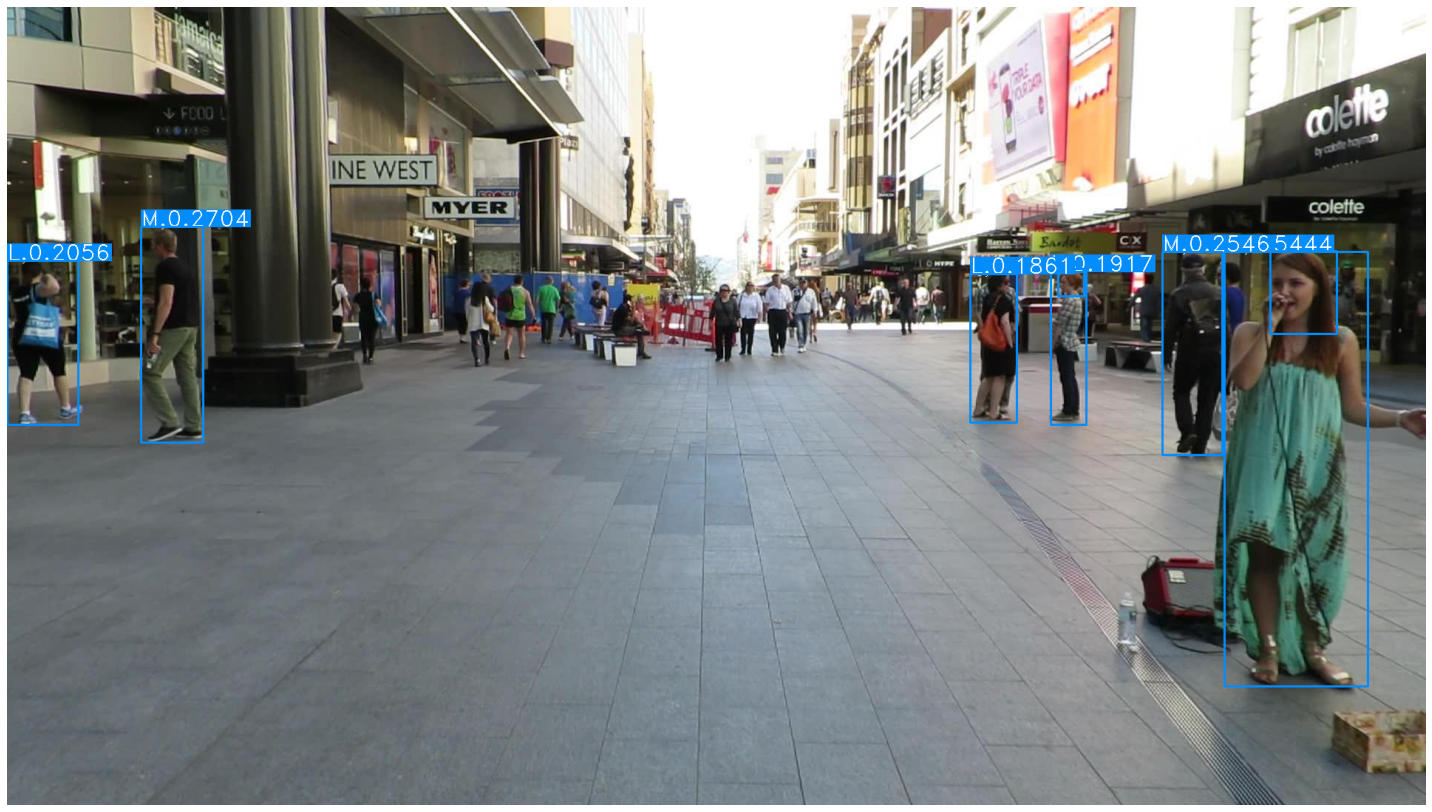

In [24]:
import json
import utils
import matplotlib.pyplot as plt
%matplotlib inline

def determine_range(bbox_ratio, close_lim:float=0.6, long_lim:float=0.25):
    if bbox_ratio > close_lim:
        return "close"
    if bbox_ratio < long_lim:
        return "long"
    return "mid"

# imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/curated/MOT17-08_resampled-fin/000555.jpg"
imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/curated/MOT17-07_resampled-fin/000497.jpg"
with open("/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/MOT17-07/annotations/curated.json", 'r') as f:
    ann = json.load(f)[imgpath]

img = plt.imread(imgpath)
total_height = img.shape[0]
for a in ann:
    # if a['gender'] != 1:
    #     continue
    det_height = a['bbb'][3]-a['bbb'][1]
    a['age'] = round(det_height/total_height, 4)
    a['gender'] = determine_range(a['age']).capitalize()
    print()
utils.show(utils.draw_annotation(imgpath, ann, color=(252, 140, 3)), size=(20, 20), cformat="bgr")

In [ ]:
import matplotlib.pyplot as plt

def metrics(pairs):
    tp = fp = fn = 0
    for annpair, gtpair in pairs:
        fn += int(annpair is None)
        fp += int(gtpair is None)
        tp += int(not (annpair is None or gtpair is None))
    if tp == 0:
        return {"recall":0, "precision":0, "f1":0}
    precision, recall = tp/(tp+fp), tp/(tp+fn)
    f1score = 2/(1/recall + 1/precision)
    return {"recall":recall, "precision":precision, "f1":f1score}

# Effective range
root = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body"
results = {'close':{'tp':0, 'fp':0, 'fn':0},
           'mid':{'tp':0, 'fp':0, 'fn':0},
           'long':{'tp':0, 'fp':0, 'fn':0}}
# for curated_path in tqdm([os.path.join(root, seq, "annotations/curated.json") for seq in os.listdir(root) if "MOT" in seq]):
testing_path = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/MOT17-09/annotations/curated.json"
with open(testing_path, 'r') as testing_curated:
    GT_MOT17 = json.load(testing_curated)
    for imgpath in tqdm(GT_MOT17, leave=False):
        img = plt.imread(imgpath)
        total_height = img.shape[0]
        pred_boxes, gt_boxes = extract_field(ensemble.predict(imgpath), field="bbb"), extract_field(GT_MOT17[imgpath], field="bbb")
        for pred_idx, gt_idx in bbox_pairing(pred_boxes, gt_boxes):
            if gt_idx is None:
                det_height = pred_boxes[pred_idx][3]-pred_boxes[pred_idx][1]
                range_ = determine_range(det_height/total_height)
                results[range_]['fp'] += 1
            else:
                det_height = (gt_boxes[gt_idx][3]-gt_boxes[gt_idx][1])*(gt_boxes[gt_idx][2]-gt_boxes[gt_idx][0])
                range_ = determine_range(det_height/total_height)
                if pred_idx is None:
                    results[range_]['fn'] += 1
                else:
                    results[range_]['tp'] += 1

  0%|          | 0/9 [00:17<?, ?it/s]


In [152]:
results

{'close': {'tp': 6, 'fp': 0, 'fn': 0},
 'mid': {'tp': 0, 'fp': 2, 'fn': 0},
 'long': {'tp': 0, 'fp': 6, 'fn': 0}}

In [1]:
import os
import json
import utils
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from models.ours.initial_design import EnsembleModel, extract_field, bbox_pairing
from torchmetrics.detection.mean_ap import MeanAveragePrecision


def determine_range(bbox_ratio, close_lim:float=0.65, long_lim:float=0.25):
    if bbox_ratio > close_lim:
        return "close"
    if bbox_ratio < long_lim:
        return "long"
    return "mid"

def torchmetrics_formatter(preds_by_frames, bpart:str, gt:bool=False):
    if bpart not in ['body', 'face']:
        raise ValueError(f"Body part {bpart} not in ['body', 'face'].")
    bbox_field, score_field = ('bbb', 'body_score') if bpart == "body" else ('fbb', 'face_score')
    frames = []
    for preds in preds_by_frames:
        boxes, scores = [], []
        for bbox, score in [(p[bbox_field], p[score_field] if not gt else None) for p in preds if p[bbox_field] is not None]:
            boxes.append(bbox); scores.append(score) if not gt else None
        if gt:
            frames.append({'boxes':torch.tensor(boxes), 'labels':torch.tensor([0]*len(boxes))})
        else:
            frames.append({'boxes':torch.tensor(boxes), 'labels':torch.tensor([0]*len(boxes)), 'scores':torch.tensor(scores)})
    return frames


# Initialize and load model
ensemble = EnsembleModel(conf_thrs=0.9)
state_dict_path = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/trained_models/body/exp_baseline_finalmodel/state_dict.pth"
ensemble.load_body_statedict(torch.load(state_dict_path, map_location=torch.device('cpu')))

# Inference
testing_path = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/MOT17-09/annotations/curated.json"
close_lim, long_lim = 0.8, 0.2
preds, targets = [], []
er_results = {
    'close':{'tp':0, 'fp':0, 'fn':0},
    'mid':{'tp':0, 'fp':0, 'fn':0},
    'long':{'tp':0, 'fp':0, 'fn':0}
}
gar_results = {
    'close':{'predictions':0, 'correct_age':0, 'correct_gender':0},
    'mid':{'predictions':0, 'correct_age':0, 'correct_gender':0},
    'long':{'predictions':0, 'correct_age':0, 'correct_gender':0}
}
mca_results = {
    'Young':{'predictions':0, 'correct':0},
    'Adult':{'predictions':0, 'correct':0},
    'Old':{'predictions':0, 'correct':0}
}
imgs_failed_gar = []
with open(testing_path, 'r') as testing_curated:
    GT_MOT17 = json.load(testing_curated)
for imgpath in tqdm(GT_MOT17, leave=False):
    pred, gt = ensemble.predict(imgpath), GT_MOT17[imgpath]
    preds.append(pred)
    targets.append(gt)

    predr, gtr = utils.preds_reformat(pred), utils.preds_reformat(gt)
    print(pred, predr)
    img = plt.imread(imgpath)
    total_height = img.shape[0]
    pred_boxes, gt_boxes = extract_field(pred, field="bbb"), extract_field(gt, field="bbb")
    failed_gar = False
    for pred_idx, gt_idx in bbox_pairing(pred_boxes, gt_boxes):
        # Detection evaluation
        if gt_idx is None:
            det_height = pred_boxes[pred_idx][3]-pred_boxes[pred_idx][1]
            range_ = determine_range(det_height/total_height, close_lim, long_lim)
            er_results[range_]['fp'] += 1
        else:
            det_height = (gt_boxes[gt_idx][3]-gt_boxes[gt_idx][1])*(gt_boxes[gt_idx][2]-gt_boxes[gt_idx][0])
            range_ = determine_range(det_height/total_height, close_lim, long_lim)
            if pred_idx is None:
                er_results[range_]['fn'] += 1
            else:
                er_results[range_]['tp'] += 1
                # Gender and Age Recognition evaluation
                gar_results[range_]['predictions'] += 1
                gar_results[range_]['correct_gender'] += int(predr[pred_idx]['gender'] == gtr[gt_idx]['gender'])
                gar_results[range_]['correct_age'] += int(predr[pred_idx]['age'] == gtr[gt_idx]['age'])
                if predr[pred_idx]['age'] != gtr[gt_idx]['age'] or predr[pred_idx]['gender'] != gtr[gt_idx]['gender']:
                    failed_gar = True
                # Mean Class Average for Age
                mca_results[gtr[gt_idx]['age']]['predictions'] += 1
                mca_results[gtr[gt_idx]['age']]['correct'] += int(predr[pred_idx]['age'] == gtr[gt_idx]['age'])
    if failed_gar:
        imgs_failed_gar.append(imgpath)
# Final step for effective range and GAR results
for range_ in er_results:
    # Effective range
    er_results[range_]['precision'] = er_results[range_]['tp']/(er_results[range_]['tp']+er_results[range_]['fp']) if er_results[range_]['tp']+er_results[range_]['fp'] != 0 else None
    er_results[range_]['recall'] = er_results[range_]['tp']/(er_results[range_]['tp']+er_results[range_]['fn']) if er_results[range_]['tp']+er_results[range_]['fn'] != 0 else None
    er_results[range_]['f1'] = 2/(1/er_results[range_]['precision']+1/er_results[range_]['recall']) if er_results[range_]['precision'] and er_results[range_]['recall'] else None
    # GAR
    gar_results[range_]['gender_accuracy'] = gar_results[range_]['correct_gender']/gar_results[range_]['predictions'] if gar_results[range_]['predictions'] != 0 else None
    gar_results[range_]['age_accuracy'] = gar_results[range_]['correct_age']/gar_results[range_]['predictions'] if gar_results[range_]['predictions'] != 0 else None
# Detection metrics
det_measure = MeanAveragePrecision()
det_measure.update(torchmetrics_formatter(preds, "body"), torchmetrics_formatter(targets, "body", gt=True))
det_results = det_measure.compute()

Age model state dict has been successfully loaded.
Gender model state dict has been successfully loaded.


  1%|          | 1/105 [00:04<07:16,  4.20s/it]

[{'bbb': (996, 240, 1309, 994), 'fbb': (1137, 266, 1206, 359), 'body_score': 0.9995657801628113, 'face_score': 0.99889576, 'age': 1.114974558353424, 'gender': 0.5432729758322239}, {'bbb': (450, 402, 559, 737), 'fbb': (484, 409, 511, 444), 'body_score': 0.9977344274520874, 'face_score': 0.9980738, 'age': 1.114974558353424, 'gender': 0.998018741607666}, {'bbb': (1299, 125, 1603, 981), 'fbb': (1374, 161, 1454, 259), 'body_score': 0.9997174143791199, 'face_score': 0.99654454, 'age': 1.1696802377700806, 'gender': 0.9997032284736633}, {'bbb': (319, 423, 436, 735), 'fbb': (378, 429, 405, 465), 'body_score': 0.9990116357803345, 'face_score': 0.9931832, 'age': 0.9536893963813782, 'gender': 0.5163826514035463}, {'bbb': (0, 289, 206, 926), 'fbb': None, 'body_score': 0.9977174997329712, 'face_score': None, 'age': 1.018034815788269, 'gender': 0.3294125497341156}, {'bbb': (910, 516, 942, 628), 'fbb': None, 'body_score': 0.9774815440177917, 'face_score': None, 'age': 1.2456833124160767, 'gender': 0.2

KeyboardInterrupt: 

In [3]:
from pprint import pprint
print(f"A total of {len(preds)} frames have been evaluated.")
pprint(er_results)

A total of 105 frames have been evaluated.
{'close': {'f1': 0.9905787348586811,
           'fn': 13,
           'fp': 1,
           'precision': 0.9986431478968792,
           'recall': 0.9826435246995995,
           'tp': 736},
 'long': {'f1': None,
          'fn': 0,
          'fp': 112,
          'precision': 0.0,
          'recall': None,
          'tp': 0},
 'mid': {'f1': None,
         'fn': 0,
         'fp': 79,
         'precision': 0.0,
         'recall': None,
         'tp': 0}}


In [57]:
pprint(det_results)

{'map': tensor(0.7104),
 'map_50': tensor(0.9588),
 'map_75': tensor(0.8601),
 'map_large': tensor(0.7177),
 'map_medium': tensor(0.5499),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.1196),
 'mar_10': tensor(0.7640),
 'mar_100': tensor(0.7666),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.7716),
 'mar_medium': tensor(0.6576),
 'mar_small': tensor(-1.)}


In [58]:
pprint(gar_results)

{'close': {'age_accuracy': 0.6467391304347826,
           'correct_age': 476,
           'correct_gender': 425,
           'gender_accuracy': 0.5774456521739131,
           'predictions': 736},
 'long': {'age_accuracy': None,
          'correct_age': 0,
          'correct_gender': 0,
          'gender_accuracy': None,
          'predictions': 0},
 'mid': {'age_accuracy': None,
         'correct_age': 0,
         'correct_gender': 0,
         'gender_accuracy': None,
         'predictions': 0}}


In [4]:
pprint(mca_results)

{'Adult': {'correct': 462, 'predictions': 487},
 'Old': {'correct': 6, 'predictions': 154},
 'Young': {'correct': 8, 'predictions': 95}}


In [25]:
from models.ours.initial_design import EnsembleModel
ensemble = EnsembleModel()

In [ ]:
age, gender = [pred.detach().cpu().numpy()[0] for pred in ensemble.body_branch.body_predictor(gt_det)]
'gender':gender[0], 'age':age[0]

In [3]:
import torch
from models.ours.initial_design import EnsembleModel
model = EnsembleModel()
model.load_body_sdict(torch.load("/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/trained_models/body/exp_baseline_finalmodel/state_dict.pth", map_location=torch.device('cpu')))
imgpath = "/home/emili/Documents/Universitat/TFG/cv-gender-age-recognition/data/body/curated/MOT17-07_resampled-fin/000017.jpg"
model.predict(imgpath)

Age model state dict has been successfully loaded.
Gender model state dict has been successfully loaded.


[{'bbb': (1583, 374, 1916, 1056),
  'fbb': None,
  'body_score': 0.9997664093971252,
  'face_score': None,
  'age': 0.7465417385101318,
  'gender': 0.009571660310029984},
 {'bbb': (911, 324, 1010, 580),
  'fbb': None,
  'body_score': 0.9987351298332214,
  'face_score': None,
  'age': 1.9245575666427612,
  'gender': 0.9434337019920349},
 {'bbb': (1357, 352, 1397, 459),
  'fbb': None,
  'body_score': 0.9974203109741211,
  'face_score': None,
  'age': 0.6633168458938599,
  'gender': 0.015102536417543888},
 {'bbb': (1012, 308, 1144, 666),
  'fbb': None,
  'body_score': 0.9967079162597656,
  'face_score': None,
  'age': 1.2299491167068481,
  'gender': 0.00959610566496849},
 {'bbb': (254, 324, 320, 471),
  'fbb': None,
  'body_score': 0.9938581585884094,
  'face_score': None,
  'age': 0.704929530620575,
  'gender': 0.4016004502773285},
 {'bbb': (1204, 333, 1340, 686),
  'fbb': None,
  'body_score': 0.9932172894477844,
  'face_score': None,
  'age': 1.2299491167068481,
  'gender': 0.006339513